In [1]:
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
import torch

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor
from vol_predict.loss.loss import Loss

from vol_predict.models.dl.sigma_lstm_predictor import (
    SigmaLSTMPredictor as Model,
)
from vol_predict.models.baselines.naive_predictor import NaivePredictor as Baseline

from run import run_backtest, initialize_sequential_runner

In [3]:
config = ExperimentConfig()
config.DATASET = AvailableDatasets.BITCOIN

model_params = ModelConfig()
baseline_params = ModelConfig()

model_params.n_features = 1200
model_params.n_unique_features = 10

# Handles the features
feature_processor = OneToOnePreprocessor()

runner = initialize_sequential_runner(
    model_config=model_params,
    preprocessor=feature_processor,
    experiment_config=config,
)

Available data from 2018-06-04 23:00:00 to 2018-09-30 21:00:00


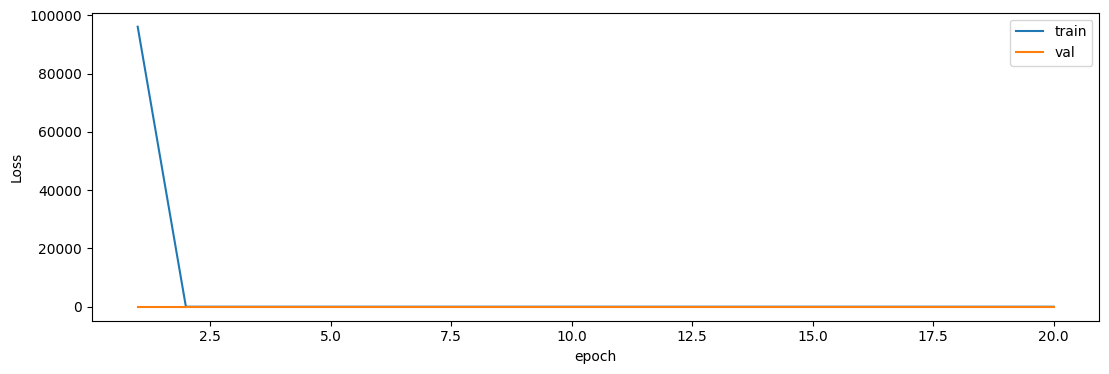

In [4]:
runner.model_config.lr = 1e-2
runner.model_config.n_epochs = 20
runner.model_config.hidden_size = 64
runner.model_config.n_layers = 3
runner.model_config.batch_size = 16
runner.model_config.optimizer = torch.optim.Adam
runner.model_config.loss = Loss.NLL
runner.model_config.dropout = 0.20

result = run_backtest(
    model_cls=Model,
    baseline_cls=Baseline,
    runner=runner,
)

In [5]:
result

(            model_loss  baseline_loss  \
 datetime                                
 2018-06-30    1.874402      -8.309954   
 2018-07-03   -3.474849      -8.035577   
 2018-07-04   -4.050474      -8.120697   
 2018-07-05   -4.694589      -8.224091   
 2018-07-06   -4.912372      -8.215822   
 ...                ...            ...   
 2018-09-26   -4.831126      -9.147779   
 2018-09-27   -5.248006      -9.004014   
 2018-09-28   -4.722682      -9.089924   
 2018-09-29   -5.990004      -9.225882   
 2018-09-30   -5.839266      -9.192994   
 
                                                  true_returns  \
 datetime                                                        
 2018-06-30  [-0.0026883667, -0.004259642, 0.0017928587, 0....   
 2018-07-03                                     [-0.008161686]   
 2018-07-04  [0.00045824194, 0.001279179, -0.00041435525, 0...   
 2018-07-05  [-0.0025450767, 0.0020725208, -0.0004954421, -...   
 2018-07-06  [0.004517578, -0.0020303084, -0.0006618499,

In [6]:
from sklearn.metrics import root_mean_squared_error

rmse = []
for date, row in result.iterrows():
    rmse.append(
        [
            date,
            root_mean_squared_error(row.true_vols, row.model_preds),
            root_mean_squared_error(row.true_vols, row.baseline_preds),
        ]
    )

rmse = pd.DataFrame(rmse, columns=["date", "model", "baseline"]).set_index("date")

AttributeError: 'tuple' object has no attribute 'iterrows'

In [7]:
rmse.mean(axis=0)

model       0.026484
baseline    0.000170
dtype: float64

In [8]:
rmse.std(axis=0)

model       0.010737
baseline    0.000158
dtype: float64

In [10]:
result.to_csv(f"Sigma_{runner.model_config.n_epochs}.csv")